# MIRA Lab 1
*Robert Martí and Sandra González-Villà*


---


## Intensity-based image registration
In this notebook you have the code of a fully working registration framework, implementing a rigid registration algorithm which minimizes the sum of squared distances (SSD). Read and understand the following functions and answer the questions asked through the notebook. Then, complete the assigned tasks.

In [1]:
from scipy.optimize import minimize
from scipy.ndimage import map_coordinates
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'scipy'

In [ ]:
def affine_transform_2d_double(Iin, M, order=3, mode=2, ImageSize=None):

    boundaries = ['reflect', 'grid-mirror', 'constant', 'grid-constant',
                  'nearest', 'mirror', 'grid-wrap', 'wrap']

    if ImageSize is None:
        ImageSize = [Iin.shape[0], Iin.shape[1]]

    if order not in np.arange(6):
        raise ValueError('Invalid order value')

    if mode not in np.arange(8):
        raise ValueError('Invalid mode value')

    boundary = boundaries[mode] # default = constant

    x, y = np.meshgrid(np.arange(ImageSize[1]), np.arange(ImageSize[0]))

    mean_out = np.array(ImageSize) / 2
    mean_in = np.array(Iin.shape[:2]) / 2

    xd = x - mean_out[1]
    yd = y - mean_out[0]

    Tlocalx = mean_in[1] + M[0, 0] * xd + M[0, 1] * yd + M[0, 2] * 1
    Tlocaly = mean_in[0] + M[1, 0] * xd + M[1, 1] * yd + M[1, 2] * 1

    Iout = map_coordinates(Iin, [Tlocaly, Tlocalx], order=order, mode=boundary)

    return Iout

In [ ]:
def affine_registration_function(par, scale, Imoving, Ifixed, mtype, ttype, order):

    x = par * scale

    if ttype == 'r': # rigid transformation
        M = np.array([[np.cos(x[2]), np.sin(x[2]), x[0]],
                      [-np.sin(x[2]), np.cos(x[2]), x[1]],
                      [0, 0, 1]])
    else:
        raise ValueError('Unknown registration type')

    I3 = affine_transform_2d_double(Imoving, M, order)

    if mtype == 'sd':  # squared differences
        e = np.sum((I3 - Ifixed)**2) / I3.size
    else:
        raise ValueError('Unknown metric type')

    return e

In [ ]:
def affineReg2D(Imoving_path, Ifixed_path, mtype='sd', ttype='r', tscale=[1,1,0.001], epsilon=0.001, order=3):

    Imoving = rgb2gray(imread(Imoving_path)[:,:,0:3]).astype(np.double)
    Ifixed = rgb2gray(imread(Ifixed_path)[:,:,0:3]).astype(np.double)

    scale = np.array(tscale)

    if ttype == 'r':
        x = np.array([0, 0, 0])
        if scale.size != 3:
          raise ValueError('Invalid scale')

    else:
        raise ValueError('Unknown registration type')

    x = x / scale

    result = minimize(
        lambda par: affine_registration_function(par, scale.astype(np.double), Imoving, Ifixed, mtype, ttype, order),
        x.astype(np.double), options={'eps':epsilon, 'maxls':50},
        method='L-BFGS-B'
    )

    x = result.x
    x = x * scale

    print(f'Parameters: {x}')

    if ttype == 'r': # rigid transformation
        M = np.array([[np.cos(x[2]), np.sin(x[2]), x[0]],
                      [-np.sin(x[2]), np.cos(x[2]), x[1]],
                      [0, 0, 1]])


    Icor = affine_transform_2d_double(Imoving, M, order)


    # Show the registration results
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(Ifixed, cmap='gray')
    plt.title('Fixed Image')

    plt.subplot(2, 2, 2)
    plt.imshow(Imoving, cmap='gray')
    plt.title('Moving Image')

    plt.subplot(2, 2, 3)
    plt.imshow(Icor, cmap='gray')
    plt.title('Transformed Moving Image')

    plt.subplot(2, 2, 4)
    plt.imshow(np.abs(Ifixed - Icor), cmap='viridis')
    plt.title(f'Registration Error (mtype={mtype}, ttype={ttype}, scale={scale})')

    plt.tight_layout()
    plt.show()

    return Icor, M

# Some questions about the provided code


**QUESTION 1**: Identify each of the components of the image registration framework, state their <u>type</u> and where they can be found (<u>function</u> and <u>line number</u>)

*Your answer here*

**QUESTION 2**: What is the function of the `scale` vector?

*Your answer here*

**QUESTION 3**: Where is the center of rotation of the transformation?

*Your answer here*

# Perform a test registration


In [ ]:
from google.colab import files

#Load the four brain images provided with the notebook
uploaded = files.upload()

Saving brain1.png to brain1.png
Saving brain2.png to brain2.png
Saving brain3.png to brain3.png
Saving brain4.png to brain4.png


Parameters: [ 2.18970320e+01 -2.39967496e+01 -1.83637572e-05]


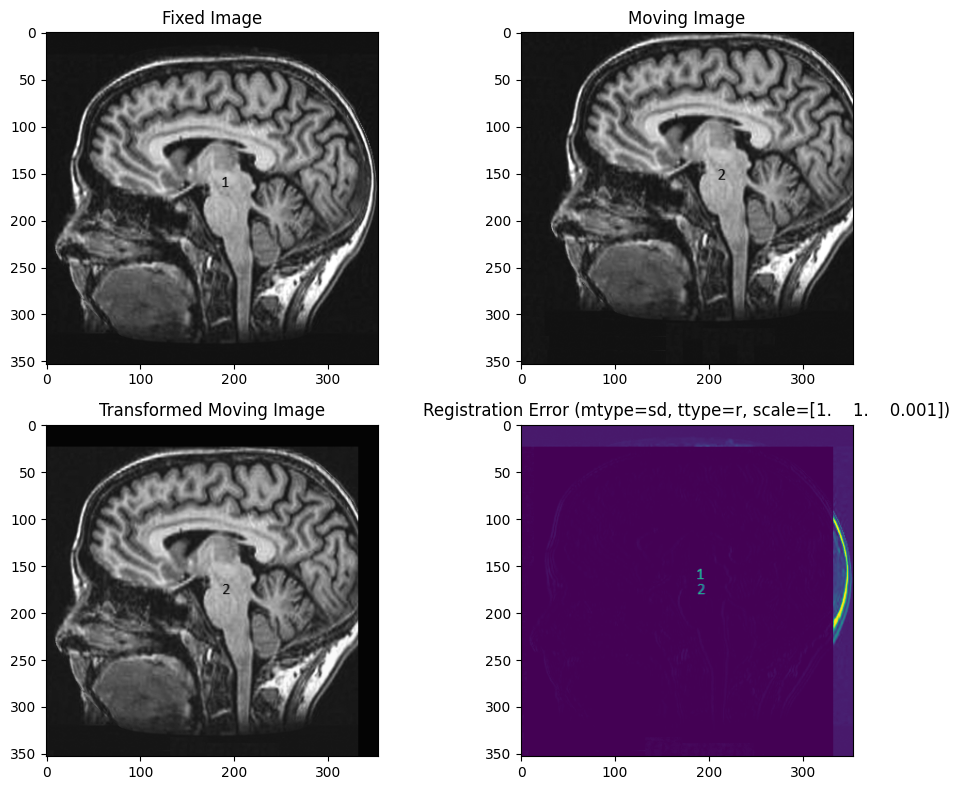


Registration took 6 sec.


In [ ]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain2.png", "brain1.png", 'sd', 'r')
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

# Let's add some extra functionality to the framework

**TASK 1**: Add two new similarity metrics to the framework:

1.   Normalized cross-correlation (NCC)
2.   Normalized gradient correlation (NGC)

In [ ]:
#Your code here

**TASK 2**: Modify the framework to be able to deal with full affine 2D transformations.
   - **QUESTION 4**: Justify how you initialize the transformation.

*Your answer here*



**TASK 3**: Implement the above modifications in a multi-resolution registration framework. The number of resolutions should be a parameter of the framework.
  - **QUESTION 5**: Discuss how each resolution is initialized.
  - **QUESTION 6**: Justify the benefits of multi-resolution in terms of computation time and/or accuracy of the final result, compared to a single resolution.

*Your answers here*



# Let's try your implementation

**TASK 4**: Show some registration results using brain1.png, brain2.png, brain3.png, and brain4.png with the different combinations of the registration framework: different <u>metrics</u>, <u>transformations</u> and <u>multi-resolution levels</u>.



In [ ]:
#Your code here

**TASK 5**: For selected (representative) cases, plot the metric against iterations, computation time, registration results and final error (<u>propose a quantitative error measure</u>).

In [ ]:
#Your code here

**QUESTION 7**: Are the results what you were expecting? If not, explain why.

*Your answer here*